# CIFAR图像识别-CNN

该部分将使用CNN实现图像识别

In [1]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

/Users/yangjian/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print("TensorFlow Version: %s" % tf.__version__)

TensorFlow Version: 1.7.0


# 加载数据

In [3]:
# 加载数据
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    加载单批量的数据
    
    参数：
    cifar10_dataset_folder_path: 数据存储目录
    batch_id: 指定batch的编号
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    
    # features and labels
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']

    return features, labels

In [4]:
# 加载所有训练数据
cifar10_path = '/Users/yangjian/Downloads/cifar-10-batches-py' # 本地路径
# 共有5个batch的训练数据
x_train, y_train = load_cfar10_batch(cifar10_path, 1)
for i in range(2, 6):
    features, labels = load_cfar10_batch(cifar10_path, i)
    x_train, y_train = np.concatenate([x_train, features]), np.concatenate([y_train, labels])

In [5]:
# 加载测试数据
with open(cifar10_path + '/test_batch', mode='rb') as file:
    batch = pickle.load(file, encoding='latin1')
    x_test = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    y_test = batch['labels']

# 图片概要

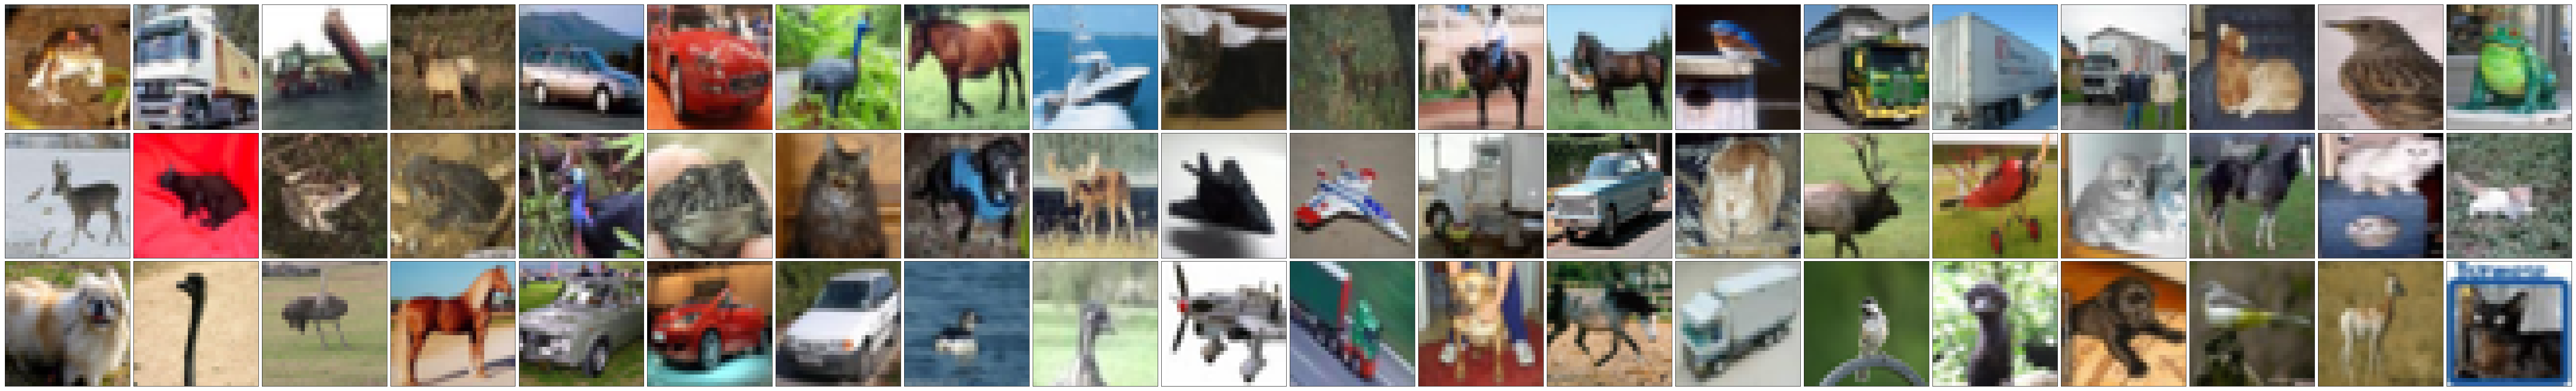

In [6]:
# 显示图片
fig, axes = plt.subplots(nrows=3, ncols=20, sharex=True, sharey=True, figsize=(80,12))
imgs = x_train[:60]

for image, row in zip([imgs[:20], imgs[20:40], imgs[40:60]], axes):
    for img, ax in zip(image, row):
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)


# 数据预处理

- 输入数据的处理
- 标签处理

### 输入数据处理

对输入数据进行归一化

In [7]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

# 重塑
x_train_rows = x_train.reshape(x_train.shape[0], 32 * 32 * 3)
x_test_rows = x_test.reshape(x_test.shape[0], 32 * 32 * 3)

# 归一化
x_train = minmax.fit_transform(x_train_rows)
x_test = minmax.fit_transform(x_test_rows)

In [8]:
# 重新变为32 x 32 x 3
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)

### 目标变量处理

对目标变量进行one-hot编码

In [9]:
from sklearn.preprocessing import LabelBinarizer
n_class = 10 #总共10类
lb = LabelBinarizer().fit(np.array(range(n_class)))

y_train = lb.transform(y_train)
y_test = lb.transform(y_test)

### 划分train与val

In [10]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8
x_train_, x_val, y_train_, y_val = train_test_split(x_train, 
                                                    y_train, 
                                                    train_size=train_ratio,
                                                    random_state=123)

# 构建网络

### 参数设置

In [11]:
img_shape = x_train.shape
keep_prob = 0.6
epochs=5
batch_size=64

### 输入与标签

In [12]:
inputs_ = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs_')
targets_ = tf.placeholder(tf.float32, [None, n_class], name='targets_')

### 构造网络

In [13]:
# 第一层卷积加池化
# 32 x 32 x 3 to 32 x 32 x 64
conv1 = tf.layers.conv2d(inputs_, 64, (2,2), padding='same', activation=tf.nn.relu, 
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
# 32 x 32 x 64 to 16 x 16 x 64
conv1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')

# 第二层卷积加池化
# 16 x 16 x 64 to 16 x 16 x 128
conv2 = tf.layers.conv2d(conv1, 128, (4,4), padding='same', activation=tf.nn.relu,
                         kernel_initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.1))
# 16 x 16 x 128 to 8 x 8 x 128
conv2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')

# 重塑输出
shape = np.prod(conv2.get_shape().as_list()[1:])
conv2 = tf.reshape(conv2,[-1, shape])

# 第一层全连接层
# 8 x 8 x 128 to 1 x 1024
fc1 = tf.contrib.layers.fully_connected(conv2, 1024, activation_fn=tf.nn.relu)
fc1 = tf.nn.dropout(fc1, keep_prob)

# 第二层全连接层
# 1 x 1024 to 1 x 512
fc2 = tf.contrib.layers.fully_connected(fc1, 512, activation_fn=tf.nn.relu)

# logits层
# 1 x 512 to 1 x 10
logits_ = tf.contrib.layers.fully_connected(fc2, 10, activation_fn=None)
logits_ = tf.identity(logits_, name='logits_')

# cost & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits_, labels=targets_))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

# accuracy
correct_pred = tf.equal(tf.argmax(logits_, 1), tf.argmax(targets_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# 训练模型

In [ ]:
save_model_path='./test_cifar'
count = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for batch_i in range(img_shape[0]//batch_size-1):
            feature_batch = x_train_[batch_i * batch_size: (batch_i+1)*batch_size]
            label_batch = y_train_[batch_i * batch_size: (batch_i+1)*batch_size]
            train_loss, _ = sess.run([cost, optimizer],
                                     feed_dict={inputs_: feature_batch,
                                                targets_: label_batch})

            val_acc = sess.run(accuracy,
                               feed_dict={inputs_: x_val,
                                          targets_: y_val})
            
            if(count%10==0):
                print('Epoch {:>2}, Train Loss {:.4f}, Validation Accuracy {:4f} '.format(epoch + 1, train_loss, val_acc))
            
            count += 1
    
    # 存储参数
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)                         


Epoch  1, Train Loss 2.3577, Validation Accuracy 0.095400 


# 测试结果

In [30]:
import random

In [ ]:
loaded_graph = tf.Graph()
test_batch_size= 100
with tf.Session(graph=loaded_graph) as sess:
    # 加载模型
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)

    # 加载tensor
    loaded_x = loaded_graph.get_tensor_by_name('inputs_:0')
    loaded_y = loaded_graph.get_tensor_by_name('targets_:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits_:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

    # 计算test的准确率
    test_batch_acc_total = 0
    test_batch_count = 0
    
    print("Begin test...")
    for batch_i in range(x_test.shape[0]//test_batch_size-1):
        test_feature_batch = x_test[batch_i * test_batch_size: (batch_i+1)*test_batch_size]
        test_label_batch = y_test[batch_i * test_batch_size: (batch_i+1)*test_batch_size]
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch})
        test_batch_count += 1

    print('Test Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))